# Extended Phase Graphs: SSFP sequence

## Utils

Utility functions to create flip angle trains and plotting signals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# flip angle schedule design
def constant_flip(flip, npulses):
    """
    Constant flip angle train.
    """
    return flip * np.ones(npulses, dtype=np.float32)


def ramp_flip(flip, npulses):
    """
    Ascending linear ramp flip angle train.
    """
    return np.linspace(0, flip, dtype=np.float32)


def piecewise_flip(flip, npulses):
    """
    Ascending ramp flip angle train followed by
    descending ramp and constant train.
    """
    # divide in ramp up, ramp down and recovery
    nramp = int(np.ceil(npulses * 3 // 4))

    ramp_up = np.linspace(0, flip, int(nramp // 2), dtype=np.float32)
    ramp_down = np.linspace(flip, 5, int(nramp // 2), dtype=np.float32)
    const = 5 * np.ones(npulses - (len(ramp_up) + len(ramp_down)), dtype=np.float32)

    return np.concatenate((ramp_up, ramp_down, const))

def jiang_flip(flip=[35, 43, 70, 45, 27], npulses=1000, delta_flip=5, segment_length=200, n_segments=5, delta_segment=10):
        """
        Sinusoidal pattern as in Jiang SSFP paper.
        """
        # get maximum flip angle
        flip = np.asarray(flip, dtype=np.float32) - delta_flip
        
        # build schedule
        n = np.arange(segment_length, dtype=np.float32) + 1
        rest = np.zeros(delta_segment, dtype=np.float32)
        out = segment = np.concatenate((np.sin(n * np.pi / segment_length) * flip[0], rest))
        
        for i in range(1, n_segments):
            segment = np.concatenate((np.sin(n * np.pi / segment_length) * flip[i], rest))
            out = np.concatenate((out, segment))
            
        return out[:npulses]

def malik_flip():
        """
        Sinusoidal pattern as in Jiang SSFP paper.
        """
        ss = np.arange(16).astype(np.float32) / 15.0
        ss = np.repeat(ss, 2)
        ss = np.concatenate((ss, np.flip(ss)))
        ss = np.ascontiguousarray(ss)
        s0 = np.zeros(16, dtype=np.float32)
        return np.sin(np.concatenate((s0, s0, ss, ss, s0, s0, ss)) * np.pi / 2.0) * 40.0

# slice profile (from MyoQMRI)
def slice_profile():
    """
    Compute sliceprofile.
    """
    # compute
    sliceprof = _calcSliceprof(90.0, 8)

    # reduce
    sliceprof = _reduceSliceProf(sliceprof, 8)

    # normalize
    sliceprof /= sliceprof[0]

    # flip
    sliceprof = np.flip(sliceprof)

    return np.ascontiguousarray(sliceprof)
    
def _calcSliceprof(nomFA, tbw): 
    t = np.linspace(-tbw/2, tbw/2, 1000)
    pulse = np.multiply(np.hanning(len(t)), np.sinc(t))
    total = np.sum(pulse)
    pulse = np.radians(pulse / total * nomFA)
    

    # alternative a bit less precise but errors ~1deg
    h = np.abs(np.fft.fft(pulse,5210*2))
    
    sliceprof = np.abs(h[0:199])
    sliceprof = sliceprof/np.max(sliceprof)*nomFA
    return sliceprof

# binning of the slice profile
def _reduceSliceProf(sliceprof, bins):
    lastVal = np.argwhere( sliceprof > 0.1 ).max()
    sliceprof = sliceprof[:lastVal]
    
    binsize = int(np.ceil(len(sliceprof) / bins))
    sliceprof_out = np.zeros((bins,1))
    
    for i in range(bins):
        startIndex = i*binsize
        endIndex = (i+1)*binsize-1
        if endIndex > len(sliceprof):
            endIndex = len(sliceprof)-1
        sliceprof_out[i] = sliceprof[startIndex:endIndex].mean()
    
    return sliceprof_out

# plotting
def display_pattern(input):
    plt.plot(input), plt.xlabel("TR index"), plt.ylabel("flip [deg]")
    plt.xlim([0, len(input)])

def display_signal(input, legend=None):
    plt.subplot(2,1,1)
    plt.plot(np.abs(input))
    plt.xlim([0, len(input)])
    plt.xlabel("TR index")
    plt.ylabel("signal magnitude [a.u.]")
    plt.subplot(2,1,2)
    plt.plot(np.angle(input) / np.pi)
    plt.xlabel("TR index")
    plt.ylabel("signal phase [rad / $\pi$]")
    if legend is not None:
        plt.legend(legend)
    plt.tight_layout()

## Flip angle pattern

Here, we the same flip angle pattern as [Jiang et al.](https://onlinelibrary.wiley.com/doi/10.1002/mrm.25559)

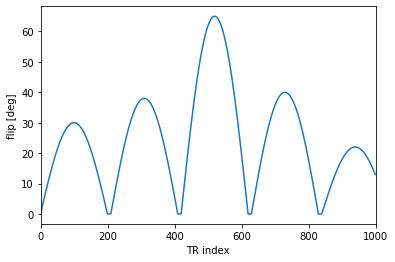

In [2]:
# design flip angle pattern
flip = jiang_flip()

# display
display_pattern(flip)

## Basic experiment

torch.Size([1, 1000, 2])


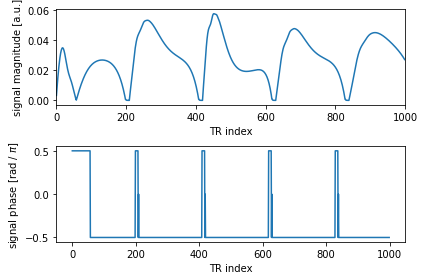

In [3]:
from deepmr import bloch

# parameters
TR = 10.0 # ms
TI = 30.0 # ms
T1 = 1000.0 # ms
T2 = 50.0 # ms

# actual simulation
sig = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=True) # SPGR
sig /= np.linalg.norm(sig)

# display
display_signal(sig)

## Slice profile effect

([<matplotlib.lines.Line2D at 0x7f65196a0eb0>],
 Text(0.5, 0, 'z [a.u.]'),
 Text(0, 0.5, 'FA / FAnom'))

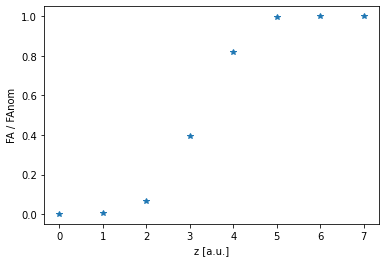

In [4]:
# calculate slice profile
sliceprof = slice_profile().squeeze()

# display
plt.plot(sliceprof, '*'), plt.xlabel("z [a.u.]"), plt.ylabel("FA / FAnom")

torch.Size([1, 1000, 2])


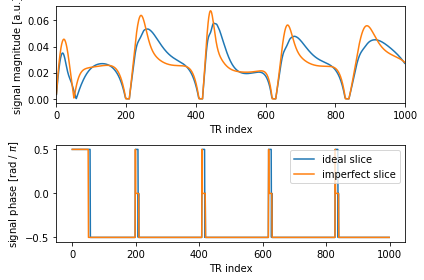

In [5]:
# actual simulation
sig_prof = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, sliceprof=sliceprof, nstates=1)
sig_prof /= np.linalg.norm(sig_prof)

# display
display_signal(np.stack((sig, sig_prof), axis=1), legend=["ideal slice", "imperfect slice"])

## Effect of Chemical Exchange and Magnetization Transfer

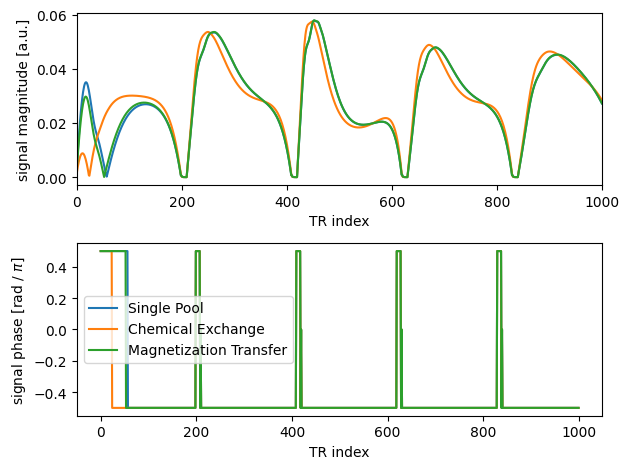

In [6]:
# chemical exchange parameters (myelin water)
fb = 0.2
T1b = 500.0 # ms
T2b = 20.0 # ms
kex = 10.0 # ms**-1
dfb = 15.0 # Hz
ex_props = {"weight_bm": fb, "T1bm": T1b, "T2bm": T2b, "kbm": kex, "chemshift_bm": dfb}

# actual simulation
sig_ex = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=True, **ex_props)
sig_ex /= np.linalg.norm(sig_ex)

# magnetization transfer (myelin macromolecules)
fm = 0.117
kmt = 36.75 #ms**-1
rf_b1rms = 6.5 # uT / deg
rf_tau = 1.0 # ms
inv_b1rms = 6.5 # uT / deg
inv_tau = 1.0 # ms
mt_props = {"weight_mt": fm, "kmt": kmt, "rf_b1rms": rf_b1rms, "rf_tau": rf_tau, "inv_b1rms": rf_b1rms, "inv_tau": inv_tau}

# actual simulation
sig_mt = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=True, **mt_props)
sig_mt /= np.linalg.norm(sig_mt)

# display
display_signal(np.stack((sig, sig_ex, sig_mt), axis=1), legend=["Single Pool", "Chemical Exchange", "Magnetization Transfer"])

## Effect of Diffusion

torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])


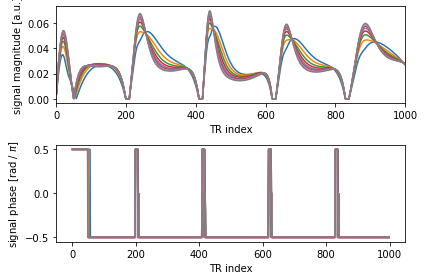

In [6]:
# chemical exchange parameters (myelin water)
D = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5] # um**2 / ms
grad_tau = 5 # ms
grad_dephasing = 32 * np.pi # rad
voxelsize = 1 # mm
grad_props = {"grad_tau": grad_tau, "grad_dephasing": grad_dephasing, "voxelsize": voxelsize}

# actual simulation
sig_diff = [bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, D=d, slice_selective_exc=True, **grad_props) for d in D]
sig_diff = [sig / np.linalg.norm(sig) for sig in sig_diff]

display_signal(np.stack([sig] + sig_diff, axis=1))

## Effect of Flow (dephasing)

torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])


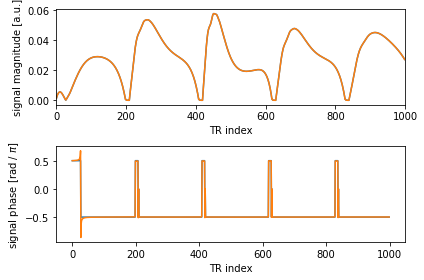

In [7]:
# motion properties
v = 1000 # cm / s
grad_tau = 5 # ms
grad_dephasing = 32 * np.pi # rad
voxelsize = 1 # mm
grad_props = {"grad_tau": grad_tau, "grad_dephasing": grad_dephasing, "voxelsize": voxelsize}

# actual simulation
sig_still = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=False)
sig_still /= np.linalg.norm(sig_still)
sig_moving = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, v=v, slice_selective_exc=False, **grad_props)
sig_moving /= np.linalg.norm(sig_moving)

display_signal(np.stack((sig_still, sig_moving), axis=1))

## Effect of Flow (inflow)

torch.Size([1, 1000, 2])
torch.Size([1, 1000, 2])


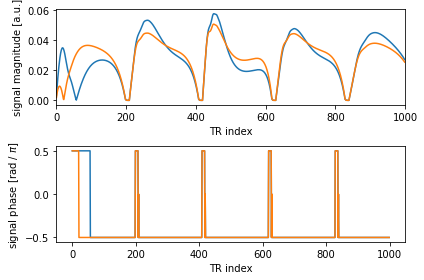

In [8]:
# motion properties
v = 1 # cm / s = 10 mm / s = 0.01 mm / ms = 0.1 mm / TR = 0.02 voxel / TR
grad_tau = 1 # ms
grad_dephasing = 0 * np.pi # artificially turn off the dephasing due to spoiling gradient while maintaing states shifting
voxelsize = 5 # mm
grad_props = {"grad_tau": grad_tau, "grad_dephasing": grad_dephasing, "voxelsize": voxelsize}

# actual simulation
sig_still = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=True, slice_selective_inv=True)
sig_still /= np.linalg.norm(sig_still)
sig_moving = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, v=v, slice_selective_exc=True, slice_selective_inv=True, **grad_props)
sig_moving /= np.linalg.norm(sig_moving)

display_signal(np.stack((sig_still, sig_moving), axis=1))

## Multiple B1+ modes

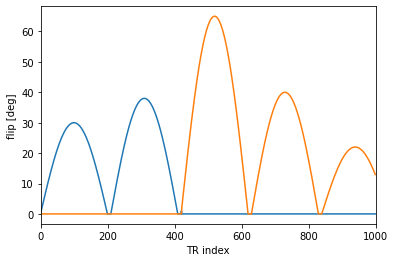

In [9]:
# prepare schedule
flip1 = flip.copy()
flip2 = flip.copy()

# mode 1: frames 1-420; mode 2: frames 421:end
flip1[421:] = 0.0
flip2[:421] = 0.0
flip = np.stack((flip1, flip2), axis=-1)

display_pattern(flip)

torch.Size([1, 1000, 2])


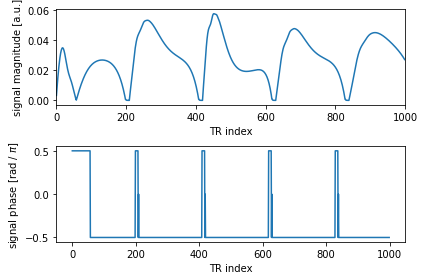

In [10]:
# actual simulation
sig = bloch.ssfp_sim(flip=flip, TR=TR, TI=TI, T1=T1, T2=T2, slice_selective_exc=True) # SPGR
sig /= np.linalg.norm(sig)

# display
display_signal(sig)